# `013` Long short-term memory (LSTM) networks

Requirements: 012 Recurrent neural networks

As we saw in the previous RNN notebook, the layers that update the hidden state in RNNs suffer from very long term dependencies that make the gradients vanish or explode:
* If a cell has a weight of 0.5, and the sequence is 50 steps long, some output will be multiplied by $0.5^{50}$, which is almost zero (or exactly zero if the floating point precision is not enough).
* If a cell has a weight of 2, and the sequence is 50 steps long, some output will be multiplied by $2^{50}$, which is roughly one quadrillion.

Some previous attempts to solve this problem used activation functions that were able to keep the gradients in a reasonable range, like the `tanh` function, that cramps an input in $(-\infty, \infty)$ into $(-1, 1)$. However, since $tanh(-4) \approx -0.999$, the gradients can still vanish, and long-term dependencies are still hard to learn.

Which is why LSTM was proposed. LSTM is a type of RNN that maintains two cell states: a long term and a short term memory. The architecture is designed in a way that the gradients can flow through the network without vanishing or exploding, so that the network can know what to remember and what to forget. It is composed of three so-called gates: the input gate, the forget gate, and the output gate.

To understand how all of this works, we first have to think of the semantics of the two used activation functions: sigmoid and tanh.

In [1]:
from json import loads
from matplotlib import pyplot as plt
from random import shuffle
from string import ascii_letters, digits
from time import time
from unicodedata import category, normalize
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

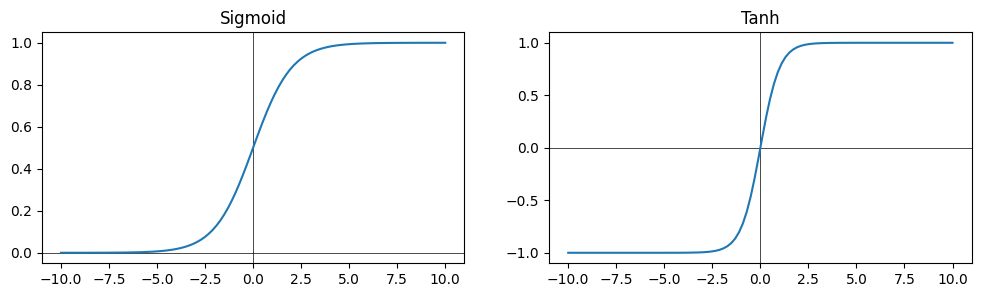

In [2]:
x = torch.linspace(-10, 10, 100)
y1 = torch.sigmoid(x)
y2 = torch.tanh(x)
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.axhline(0, color='black', lw=.5)
plt.axvline(0, color='black', lw=.5)
plt.plot(x, y1)
plt.title('Sigmoid')
plt.subplot(1, 2, 2)
plt.axhline(0, color='black', lw=.5)
plt.axvline(0, color='black', lw=.5)
plt.plot(x, y2)
plt.title('Tanh');

The sigmoid activation function takes an input and transforms it into a value between 0 and 1. If the preactivation is obtained from learnable weights, you can think as the output of the sigmoid as a faucet valve, that learns to open or close depending on the input.

In [3]:
data = torch.tensor([-3, 2, 10])  # this is our input, the water coming from the pipe to the faucet
gate = torch.tensor([0, -1, 0])  # this is our faucet, a gate that, given an input, let's it flow or not
new_hidden_state = torch.tensor([0, 1, 0])  # this is what we have already at the other side of the faucet

print(f'Output before the new data flows: {new_hidden_state}')
flow_rate = torch.sigmoid(data @ gate)  # based on the input data, we decide how much water to let flow
print(f'Flow rate: {flow_rate.item()}')
new_hidden_state = new_hidden_state + flow_rate  # we add the new water to the existing water
print(f'Output after the new data flows: {new_hidden_state}')

Output before the new data flows: tensor([0, 1, 0])
Flow rate: 0.11920291930437088
Output after the new data flows: tensor([0.1192, 1.1192, 0.1192])


Then, you can think of $tanh$ as a function that squashes the input into a value between -1 and 1. This is useful because it can learn to keep the gradients in a reasonable range.

In [4]:
new_hidden_state = new_hidden_state.tanh()
print(f'Output after the activation function: {new_hidden_state}')

Output after the activation function: tensor([0.1186, 0.8073, 0.1186])


Understanding these building blocks is crucial to understand how the LSTM works. Let's see the architecture of the LSTM cell:

In [5]:
short_term = torch.zeros(3)  # internal state of the LSTM
long_term = torch.zeros(3)  # internal state of the LSTM
input = torch.tensor([1, 2, 3], dtype=torch.float32)  # new input

# forget gate: decide how much will be preserved from the long term, using learned weights
W_f = torch.randn(3, 3)  # weights for the input
U_f = torch.randn(3, 3)  # weights for the memory
b_f = torch.randn(3)  # bias
preserve_rate = torch.sigmoid(input @ W_f + short_term @ U_f + b_f)

# input gate: decide how much of the input will be added to the memory, using learned weights
W_i = torch.randn(3, 3)  # weights for the input
U_i = torch.randn(3, 3)  # weights for the memory
b_i = torch.randn(3)  # bias
add_rate = torch.sigmoid(input @ W_i + short_term @ U_i + b_i)

# state candidate: decide what to add to the memory from the input, using learned weights
W_c = torch.randn(3, 3)  # weights for the input
U_c = torch.randn(3, 3)  # weights for the memory
b_c = torch.randn(3)  # bias
state_candidate = torch.tanh(input @ W_c + short_term @ U_c + b_c)  # note that tanh means that the values are between -1 and 1

# output gate: build an output based on the input and memory
W_o = torch.randn(3, 3)  # weights for the input
U_o = torch.randn(3, 3)  # weights for the memory
b_o = torch.randn(3)  # bias
output_rate = torch.sigmoid(input @ W_o + short_term @ U_o + b_o)

# update the memory
new_long_term = long_term * preserve_rate + state_candidate * add_rate
new_short_term = output_rate * torch.tanh(new_long_term)

# build an output
W_out = torch.randn(3, 3)  # weights for the output
b_out = torch.randn(3)  # bias
output = new_short_term @ W_out + b_out

A few things to note from the previous code:
* The forget gate is a "learnable faucet" that regulates how much of the long term memory should be kept.
* The input gate is another learnable faucet that regulates how much of the new information should make it to the long term memory.
* The state candidate is the new information that will be added to the long term memory. In this model, information ranges in $(-1, 1)$ and faucets range in $(0, 1)$. Since this is just the input info transformed, we use $tanh$ and not sigmoid.
* The memory will be updated by the forget gate and the input gate. The forget gate will decide how much of the old memory should be kept, and the input gate will decide how much of the new memory should be added.
* The output gate will decide how much of the long term memory should be outputted. This is useful because the long term memory can be used to predict the next token in a sequence, but it can also be used to predict the next hidden state in a sequence.

This is a complicated architecture, but it is very powerful. It can learn long-term dependencies and can be used in a variety of tasks, like language modeling, machine translation, and speech recognition. The folklore says that minimal RNNs usually don't work well with sequences longer than ~10 steps, while LSTMs can work well until ~1000 steps. Even though more modern architetures like Transformers can take inputs of 32k tokens and more, as of 2024, growing the sequence length is still an active field of research and remains and open challenge.

Let's replicate the testing environment from the previous notebook, but using LSTMs.

In [6]:
vocabulary = ascii_letters + digits + ' .,;\''
c2i = {c: i for i, c in enumerate(vocabulary)}
i2c = {i: c for i, c in enumerate(vocabulary)}

def vectorize_sentence(s):
	return [c2i[c] for c in normalize('NFD', s) if category(c) != 'Mn' and c in vocabulary]

In [7]:
with open('custom-data/sentences.json', encoding='utf-8') as f:
	data = loads(f.read())

languages = list(data.keys())

X, Y = [], []
sentence_size = 16
for language, sentences in data.items():
	for sentence in sentences:
		sentence = vectorize_sentence(sentence)
		for i in range(len(sentence) - sentence_size + 1):
			X.append(sentence[i:i+sentence_size])
			Y.append(languages.index(language))
ix = torch.randperm(len(X))
X = torch.tensor([X[i] for i in ix], device=device)
Y = torch.tensor([Y[i] for i in ix], device=device)

print(f'Loaded {len(X)} sentences from {len(languages)} languages using {len(vocabulary)} different characters')
print(X[0], Y[0], '->', ''.join(i2c[i.item()] for i in X[0]), languages[Y[0]])

Loaded 6750521 sentences from 8 languages using 67 different characters
tensor([11, 62, 27,  0, 15, 19,  8, 18, 19, 62, 37, 20,  8, 62, 38,  8],
       device='cuda:0') tensor(4, device='cuda:0') -> l Baptist Lui Mi en


In [8]:
def get_model(input_size, hidden_size, output_size):
	# forget gate
	W_f = torch.randn(input_size, hidden_size, device=device)
	U_f = torch.randn(hidden_size, hidden_size, device=device)
	b_f = torch.zeros(hidden_size, device=device)
	# input gate
	W_i = torch.randn(input_size, hidden_size, device=device) * .1
	U_i = torch.randn(hidden_size, hidden_size, device=device) * .1
	b_i = torch.zeros(hidden_size, device=device)
	# state candidate
	W_c = torch.randn(input_size, hidden_size, device=device) * .1
	U_c = torch.randn(hidden_size, hidden_size, device=device) * .1
	b_c = torch.zeros(hidden_size, device=device)
	# output gate
	W_o = torch.randn(input_size, hidden_size, device=device) * .1
	U_o = torch.randn(hidden_size, hidden_size, device=device) * .1
	b_o = torch.zeros(hidden_size, device=device)
	# output transformation
	W_out = torch.randn(hidden_size, output_size, device=device) * .1
	b_out = torch.zeros(output_size, device=device)
	# parameters
	parameters = W_f, U_f, b_f, W_i, U_i, b_i, W_c, U_c, b_c, W_o, U_o, b_o, W_out, b_out
	for p in parameters: p.requires_grad = True
	return parameters

def forward_character(model, input, memory):
	W_f, U_f, b_f, W_i, U_i, b_i, W_c, U_c, b_c, W_o, U_o, b_o, W_out, b_out = model
	# compute rates and candidate long term
	short_term, long_term = memory.chunk(2)
	preserve_rate = torch.sigmoid(input @ W_f + short_term @ U_f + b_f)
	add_rate = torch.sigmoid(input @ W_i + short_term @ U_i + b_i)
	state_candidate = torch.tanh(input @ W_c + short_term @ U_c + b_c)
	output_rate = torch.sigmoid(input @ W_o + short_term @ U_o + b_o)
	# update memory
	new_long_term = long_term * preserve_rate + state_candidate * add_rate
	new_short_term = output_rate * new_long_term.tanh()
	memory = torch.cat([new_short_term, new_long_term])
	# compute output
	output = new_short_term @ W_out + b_out
	return output, memory

one_hot = torch.eye(len(vocabulary), device=device)
def forward_sequence(model, input):
	memory = torch.zeros(2 * model[0].shape[1], device=device)
	for i in range(input.size(-1)):
		i = one_hot[input[..., i]]
		output, memory = forward_character(model, i, memory)
	return output

model = get_model(len(vocabulary), 256, len(languages))
print(f'Created model with {sum(p.numel() for p in model)} parameters')

Created model with 333832 parameters


In [9]:
def train(model, iterations=5000, batch_size=32, lr=0.05):
	start = time()
	criterion = torch.nn.CrossEntropyLoss()
	losses = []
	for epoch in range(iterations):
		ix = torch.randint(len(X), (batch_size,))
		xb, yb = X[ix], Y[ix]
		output = forward_sequence(model, xb)
		loss = criterion(output, yb)
		for p in model: p.grad = None
		loss.backward()
		for p in model: p.data -= lr * p.grad
		losses.append(loss.item())
		if epoch % 500 == 0:
			remaining = (time() - start) * (iterations - epoch) / (epoch + 1)
			print(f'Epoch {epoch:4} loss: {loss.item():.4f} remaining: {remaining//60:.0f}:{remaining%60:02.0f}')
	return losses

print('Training with default learning rate')
losses = train(model)
print('Training with lower learning rate')
losses.extend(train(model, lr=0.005))

Epoch    0 loss: 2.1045 remaining: 12:10
Epoch  500 loss: 2.0945 remaining: 2:42
Epoch 1000 loss: 1.6269 remaining: 2:22
Epoch 1500 loss: 1.4186 remaining: 2:03
Epoch 2000 loss: 1.2514 remaining: 1:47
Epoch 2500 loss: 1.5482 remaining: 1:29
Epoch 3000 loss: 1.3566 remaining: 1:11
Epoch 3500 loss: 1.3483 remaining: 0:54
Epoch 4000 loss: 1.2110 remaining: 0:36
Epoch 4500 loss: 1.1295 remaining: 0:18
Epoch    0 loss: 1.2418 remaining: 2:30
Epoch  500 loss: 1.0290 remaining: 2:48
Epoch 1000 loss: 0.9744 remaining: 2:26
Epoch 1500 loss: 0.8595 remaining: 2:07
Epoch 2000 loss: 0.8843 remaining: 1:47
Epoch 2500 loss: 0.9464 remaining: 1:31
Epoch 3000 loss: 0.8728 remaining: 1:12
Epoch 3500 loss: 0.7613 remaining: 0:54
Epoch 4000 loss: 0.7326 remaining: 0:36
Epoch 4500 loss: 0.9882 remaining: 0:18


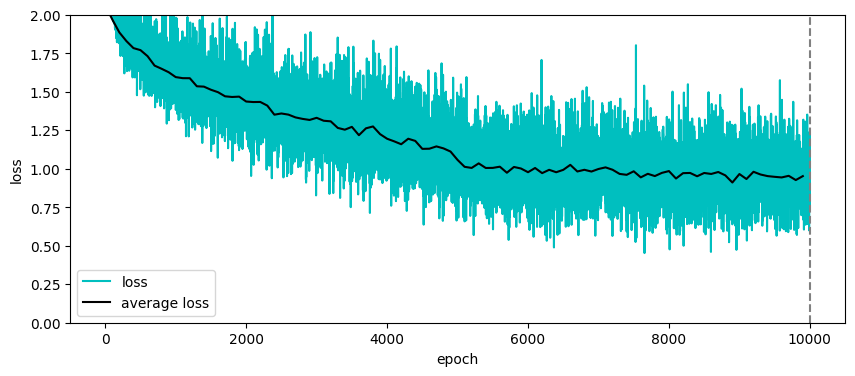

In [10]:
average_losses = torch.tensor(losses).view(-1, 100).mean(1)
plt.figure(figsize=(10, 4))
plt.plot(losses, c='c', label='loss')
plt.plot(range(0, len(losses), 100), average_losses, c='k', label='average loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 2)
plt.axvline(10000, c='gray', linestyle='--');

Again, training is really slow due to recurrency not letting us use vectorized operations. This is the main reason why, despite of it great effectiveness, RNN/LSTMs are not being used in practice that much anymore. Let's revisit the confusion matrix as in the previous notebook.

Accuracy: 0.53%


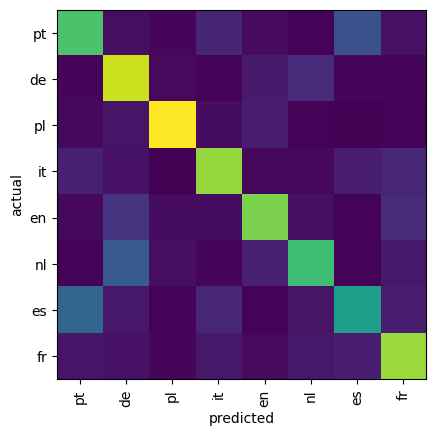

In [12]:
ix = torch.randint(len(X), (1000,))
X_test, Y_test = X[ix], Y[ix]

confusion_matrix = torch.zeros(len(languages), len(languages), device=device)
output = forward_sequence(model, X_test).argmax(1)
for true_label, predicted_label in zip(Y_test, output):
	confusion_matrix[true_label, predicted_label] += 1
confusion_matrix /= confusion_matrix.sum(1, keepdim=True)

plt.imshow(confusion_matrix.cpu().numpy())
plt.xticks(range(len(languages)), languages, rotation=90)
plt.yticks(range(len(languages)), languages)
plt.xlabel('predicted')
plt.ylabel('actual')

accuracy = confusion_matrix.diag().sum().item() / len(Y_test)
print(f'Accuracy: {100 * accuracy:.2f}%')

We see a similarly good performance as with RNNs, probably because the dataset is simple and the sequences are short, so none of the models have a hard time learning the patterns.

The performance could be furthermore improved in a number of ways. For instance, all $W_*$ and $U_*$ weights could be merged, so that in the input the short term memory and the input are concatenated and multiplied by a single weight matrix. This would reduce the number of parameters and make the model more efficient. However, it still poses the problem of having a time complexity of $O(n^2)$, where $n$ is the sequence length. Furthermore, there are other RNN architectures that are more efficient like GRU or BiGRU.